In [10]:
import argparse
import pickle
import datasets
from datasets import load_dataset
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer
import torch

DATASET_PATH = {
    'p3': 'simonycl/p3_0.5_dataset',
    'sharegpt': '/mnt/data/data-selection/data/processed/sharegpt/sharegpt_data.jsonl',
}

In [18]:
def encode_with_messages_format(example, tokenizer, max_seq_length):
    '''
    Here we assume each example has a 'messages' field Each message is a dict with 'role' and 'content' fields.
    We concatenate all messages with the roles as delimiters and tokenize them together.
    '''
    messages = example['messages']
    if len(messages) == 0:
        raise ValueError('messages field is empty.')
    
    def _concat_messages(messages):
        message_text = ""
        for message in messages:
            if message["role"] == "system":
                message_text += "<|system|>\n" + message["content"].strip() + "\n"
            elif message["role"] == "user":
                message_text += "<|user|>\n" + message["content"].strip() + "\n"
            elif message["role"] == "assistant":
                message_text += "<|assistant|>\n" + message["content"].strip() + tokenizer.eos_token + "\n"
            else:
                raise ValueError("Invalid role: {}".format(message["role"]))
        return message_text
        
    example_text = _concat_messages(messages).strip()
    tokenized_example = tokenizer(example_text, return_tensors='pt', max_length=max_seq_length, truncation=True)
    input_ids = tokenized_example.input_ids
    labels = input_ids.clone()

    return {
        'input_ids': input_ids.flatten(),
        'labels': labels.flatten(),
        'length': len(input_ids.flatten()),
    }

In [12]:
sharegpt = load_dataset('json', data_files=DATASET_PATH['sharegpt'], split='train')
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

/mnt/data/selection/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [19]:
processed_sharegpt = sharegpt.map(lambda x: encode_with_messages_format(x, tokenizer, 8072*4), batched=False, remove_columns=['messages'])
processed_sharegpt

Map: 100%|██████████| 168864/168864 [11:04<00:00, 254.02 examples/s]


Dataset({
    features: ['dataset', 'id', 'input_ids', 'labels'],
    num_rows: 168864
})

In [23]:
processed_len_sharegpt = processed_sharegpt.map(lambda x : {'length': len(x['input_ids'])}, batched=False, remove_columns=['input_ids', 'labels', 'dataset'])
processed_len_sharegpt

Map: 100%|██████████| 168864/168864 [01:45<00:00, 1596.46 examples/s]


Dataset({
    features: ['id', 'length'],
    num_rows: 168864
})

[Text(0.5, 1.0, 'Histogram of the length of examples in ShareGPT')]

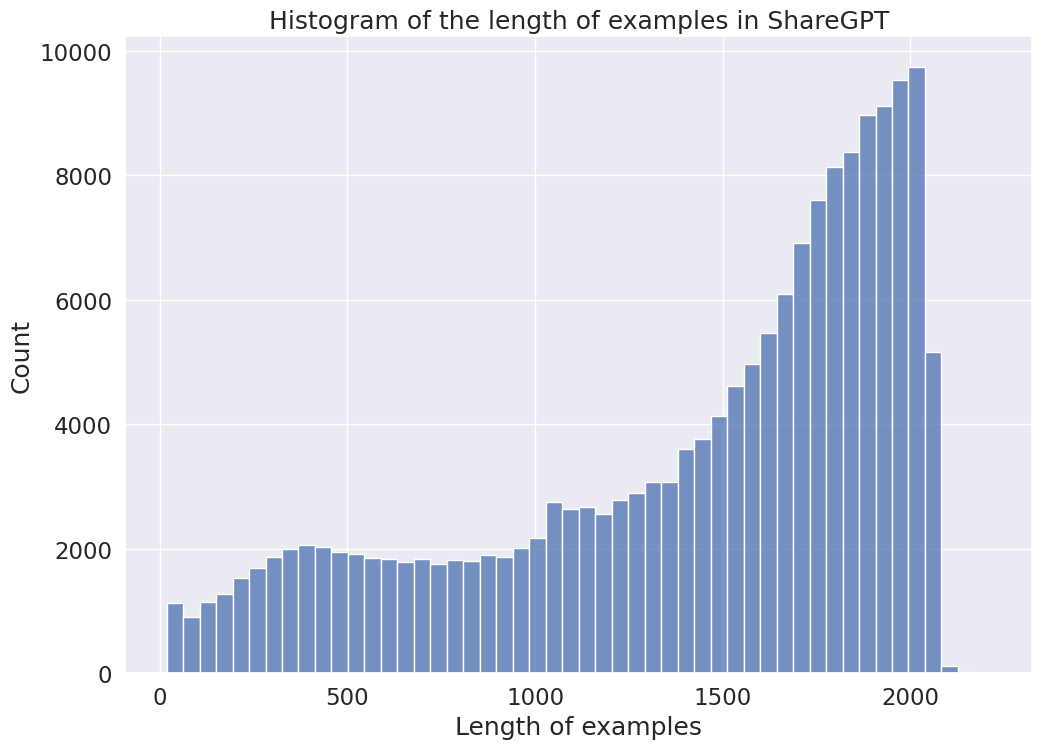

In [28]:
# plot the histogram of the length of the examples
df_len_sharegpt = processed_len_sharegpt.to_pandas()

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.5)
ax = sns.histplot(data=df_len_sharegpt, x="length", bins=50)
# ax.set(xlim=(0, 8000))
# ax.set(ylim=(0, 10000))
ax.set(xlabel='Length of examples')
ax.set(ylabel='Count')
ax.set(title='Histogram of the length of examples in ShareGPT')
